In [1]:
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt




In [90]:
# Root directory for dataset
dataroot = "train/"
testroot = "test/"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

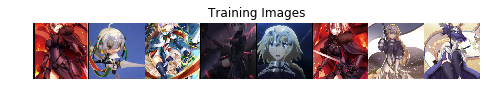

In [91]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
# Create the dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testset = dset.ImageFolder(root=testroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
                           
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [92]:
for i, (image, label) in enumerate(train_loader):
    print(label)
    vutils.save_image(image, 'torchvision_jenne.png')
    break

tensor([0, 1, 1, 1, 0, 1, 2, 2])


In [131]:
class jeanne_net(nn.Module):
    def __init__(self):
        super(jeanne_net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride=2, padding=1),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 2, stride=2, padding=1),
            nn.MaxPool2d(kernel_size = 2, stride=1),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride=2, padding=2),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 4, stride=2, padding=2),
            nn.MaxPool2d(kernel_size = 2, stride=1)
        )
        
        #全結合層
        self.dence = nn.Sequential(
            nn.Linear(64 * 16 *16, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )
        
        #順伝播
    def forward(self,x):
        
        out = self.conv_layers(x)
        #Flatten
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
        
        return out
    
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
        
        return out

In [132]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = jeanne_net().to(device)
size_check = torch.FloatTensor(10, 3, 256, 256)
size_check = size_check.to(device)
print(net.check_cnn_size(size_check).size())

torch.Size([10, 64, 16, 16])


In [133]:
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

Epoch [1/50], train_acc :0.3375, val_acc: 0.3333
Epoch [2/50], train_acc :0.3292, val_acc: 0.3333
Epoch [3/50], train_acc :0.3250, val_acc: 0.3333
Epoch [4/50], train_acc :0.3292, val_acc: 0.3333
Epoch [5/50], train_acc :0.3500, val_acc: 0.3333
Epoch [6/50], train_acc :0.3625, val_acc: 0.3333
Epoch [7/50], train_acc :0.3250, val_acc: 0.3333
Epoch [8/50], train_acc :0.3625, val_acc: 0.3667
Epoch [9/50], train_acc :0.3875, val_acc: 0.5000
Epoch [10/50], train_acc :0.4125, val_acc: 0.5444
Epoch [11/50], train_acc :0.4875, val_acc: 0.5444
Epoch [12/50], train_acc :0.4625, val_acc: 0.4778
Epoch [13/50], train_acc :0.5125, val_acc: 0.4778
Epoch [14/50], train_acc :0.5167, val_acc: 0.5111
Epoch [15/50], train_acc :0.5375, val_acc: 0.5333
Epoch [16/50], train_acc :0.5167, val_acc: 0.5778
Epoch [17/50], train_acc :0.5292, val_acc: 0.5889
Epoch [18/50], train_acc :0.5542, val_acc: 0.5778
Epoch [19/50], train_acc :0.5375, val_acc: 0.5333
Epoch [20/50], train_acc :0.5542, val_acc: 0.5444
Epoch [21

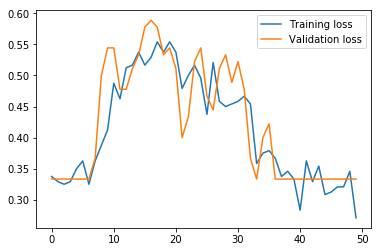

In [134]:
num_epochs =50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
import time
start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net.forward(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net.forward(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], train_acc :{:.4f}, val_acc: {:.4f}' 
                   .format(epoch+1, num_epochs, avg_train_acc, avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

end = time.time() - start

import matplotlib.pyplot as plt
%matplotlib inline
print(end)
plt.plot(train_acc_list, label='Training loss')
plt.plot(val_acc_list, label='Validation loss')
plt.legend();